# "Gradient-Based Learning Applied to Document Recognition (1998)" | LeNet-5 Architecure

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Dataset & DataLoaders

In [3]:
def get_dataloaders(batch_size=64):
    transform_pipeline = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform_pipeline
    )

    test_dataset = MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform_pipeline
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader

# Util Functions

In [4]:
def train(model, train_loader, epochs, criterion, optimizer, device):
    model.train()
    
    history = {"train_loss":[], "train_acc":[]}

    for epoch in range(epochs):
        loss_per_epoch = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            loss_per_epoch += loss.item() * batch_size

            predicted = torch.argmax(outputs, dim=1)
            total += batch_size
            correct += (predicted == labels).sum().item()
    
        loss_per_epoch /= total
        history["train_loss"].append(loss_per_epoch)
        
        accuracy_per_epoch = correct / total
        history["train_acc"].append(accuracy_per_epoch)

        print(f"Epoch: {epoch+1} / {epochs} - Train Loss: {loss_per_epoch:.4f}, Train Acc: {accuracy_per_epoch:.4f}")

    return history

In [10]:
def validate(model, test_loader, criterion, device):
    model.eval()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    accuracy = correct / total

    print(f"Val Loss: {val_loss:.4f}, Train Acc: {accuracy:.4f}")

    return val_loss, accuracy


In [6]:
def plot_learning_curves(history):

    train_losses = history["train_loss"]
    train_accs = history["train_acc"]

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Network Architecture

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model Training

In [12]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader, test_loader = get_dataloaders(64)

In [13]:
history = train(model, train_loader, 10, criterion, optimizer, device)
val_loss, val_acc = validate(model, test_loader, criterion, device)

Epoch: 1 / 10 - Train Loss: 0.2429, Train Acc: 0.9303
Epoch: 2 / 10 - Train Loss: 0.0714, Train Acc: 0.9787
Epoch: 3 / 10 - Train Loss: 0.0476, Train Acc: 0.9855
Epoch: 4 / 10 - Train Loss: 0.0367, Train Acc: 0.9887
Epoch: 5 / 10 - Train Loss: 0.0298, Train Acc: 0.9911
Epoch: 6 / 10 - Train Loss: 0.0243, Train Acc: 0.9922
Epoch: 7 / 10 - Train Loss: 0.0214, Train Acc: 0.9930
Epoch: 8 / 10 - Train Loss: 0.0167, Train Acc: 0.9947
Epoch: 9 / 10 - Train Loss: 0.0162, Train Acc: 0.9947
Epoch: 10 / 10 - Train Loss: 0.0117, Train Acc: 0.9963
Val Loss: 0.0414, Train Acc: 0.9874


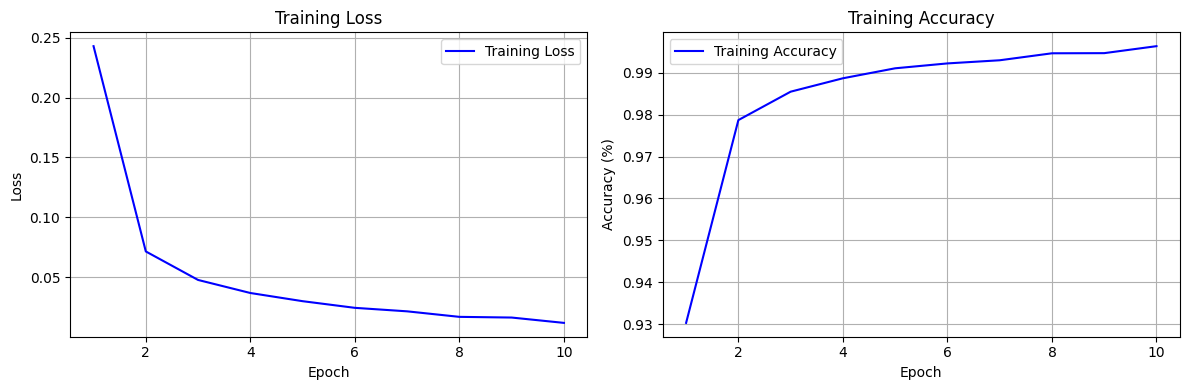

In [14]:
plot_learning_curves(history)